<a href="https://colab.research.google.com/github/Andrey-Mel/generation_txt/blob/main/generation_text_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  #ИМПОРТ БИБЛИОТЕК
  import numpy  as np
  import matplotlib.pyplot as plt
  %matplotlib inline
  
  from tensorflow.keras.models import Model, load_model #из кераса подгружаем абстрактный класс базовой модель,метод загрузки предобученной модели
  from tensorflow.keras.layers import Dense, Embedding, LSTM, Input #необходимиые слои из кераса
  from tensorflow.keras.optimizers import Adadelta, RMSprop #из кераса оптимайзеры необходимые
  from tensorflow.keras.preprocessing.sequence import pad_sequences #загружаем метод ограничения последовательности заданой длины
  from tensorflow.keras.preprocessing.text import Tokenizer #Токенайзер для обработки текста
  from tensorflow.keras import utils #загружаем утилиты кераса для one hot кодировки
  from tensorflow.keras.utils import plot_model #удобный график для визуализации архитектуры сети

  import yaml #импортируем модуль для удобной работы с файлами типа yaml



In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Парсинг данных**


In [ ]:
#Открываем файл с диалогами

corpus = open('/content/drive/My Drive/база диалоги/Диалоги(рассказы).yml', 'r')#открываем файл диалоги в режиме чтения 'r'
document = yaml.safe_load(corpus)#загружаем файл в переменную documents
conversations = document['разговоры'][:6500] #загружаем диалоги из файла в переменную conversations, УМЕНЬШИЛ РАЗМЕР БАЗЫ КОЛАБ НЕПРОПУСКАЛ НЕХВАТКА ПАМЯТИ
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога:  {}'.format(conversations[123]))



Количество пар вопрос-ответ : 6500
Пример диалога:  ['Перезалил?', 'Да вроде бы нет...']


In [ ]:
#Разбираем вопросы-ответы с проставлениеем тегов ответам
#Собираем ответы и вопросы в списки
questions = list() #список вопросов
answers = list()
#answers = [] #список ответов

#Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations:
  if len(con)>2: #если ответ содержит больше 2 предложений
    questions.append(con[0]) #вопросительную часть заносим в список вопросов
    replies = con[1:] #а последующую оставляем из остальных предложений
    ans = '' #здесь соберем ответы
    for rep in replies:
      ans += ' ' + rep
    answers.append(ans) #добавим в список ответов
  elif len(con)>1:#если на вопрос приходится 1 ответ
    questions.append(con[0]) #вопрос отправляем в список ответов
    answers.append(con[1]) #ответ в список ответов


#Очищаем строки с неопределенным типом ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип строка, то добавляем в ответы
  else:
    questions.pop(i) #если тип не строка, то удаляем из списка вопросов и сам вопрос, чтоб соответствовать размеру

#Сделаем теги-метки для начала и конца ответов
answers = []
for i in range(len(answersCleaned)):
  answers.append('<START>' + answersCleaned[i] + '<END>')

#Выведем обновленные данные на экран
print('Вопрос: {}'.format(questions[34]))
print('Ответ: {}'.format(answers[55]))


Вопрос: Вызывали меня?
Ответ: <START>Нет.<END>


In [ ]:
#Подключаем керасовский токенайзер и собираем словарь индексов
#filters='()*+_-/<=>@[\\]^~{|}`\t\n'
tokenizer = Tokenizer(filters='()*+_-/<=>@[\\]^~{|}`\t\n')
tokenizer.fit_on_texts(questions + answers)#обучаем токенайзер вопрос-ответ
vocabularyItems = list(tokenizer.word_index.items()) #список с содержимым словаря
vocabularySize = len(vocabularyItems) + 1
print('Фрагмент словаря: {}' .format(vocabularyItems[:45]))
print('Размер словаря: {}' .format(vocabularySize))



Фрагмент словаря: [('start', 1), ('end', 2), ('не', 3), ('а', 4), ('что', 5), ('ты', 6), ('я', 7), ('в', 8), ('это', 9), ('и', 10), ('как', 11), ('вы', 12), ('на', 13), ('с', 14), ('у', 15), ('же', 16), ('где', 17), ('кто', 18), ('он', 19), ('ну', 20), ('так', 21), ('нет.', 22), ('ну,', 23), ('да', 24), ('нет,', 25), ('мы', 26), ('за', 27), ('все', 28), ('мне', 29), ('то', 30), ('что?', 31), ('тебя', 32), ('да,', 33), ('вот', 34), ('да.', 35), ('куда', 36), ('почему', 37), ('меня', 38), ('еще', 39), ('к', 40), ('товарищ', 41), ('что,', 42), ('его', 43), ('тебе', 44), ('там', 45)]
Размер словаря: 14387


**Подготовка выборки**

In [ ]:
#Устанавливаем закодированные данные входные - вопросы

tokenizedQuestions = tokenizer.texts_to_sequences(questions)#разбиваем текст вопросов на последовательность индексов
maxLenQuestions = max([len(x) for x in tokenizedQuestions]) #длина самого длинного вопроса

#Делаем последовательности одной длины, заполняя нулями более короткие вопросы  PAD-SEQUENCES
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

#Преподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) #переводим в numpy массив
print('Пример оригинального вопроса на вход: {}'.format(questions[100]))
print('Пример кодированного вопроса на вход: {}'.format(encoderForInput[100]))
print('Размеры закодированного массива вопросов на вход: {}'.format(encoderForInput.shape))
print('Установленная длина вопросов на вход: {}'.format(maxLenQuestions))


Пример оригинального вопроса на вход: Какая же мораль?
Пример кодированного вопроса на вход: [ 157   16 3916    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход: (6497, 11)
Установленная длина вопросов на вход: 11


In [ ]:
#Устанавливаем раскодированные входные данные = ответы

tokenizedAnswers = tokenizer.texts_to_sequences(answers) #разбиваем текст ответов на последовательность индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers])#длина самого большого ответа

#Делаем последовательность одной длины, заполняя нулями более короткие вопросы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

#Преподготавливаем данные на вход в сеть
decoderForInput = np.array(paddedAnswers)#переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(questions[100]))
print('Пример кодированного ответа на вход: {}'.format(decoderForInput[100]))
print('Размеры закодированного массива ответов: {}'.format(decoderForInput.shape))
print('Установленная длина ответов на вход: {}'.format(maxLenAnswers))



Пример оригинального ответа на вход: Какая же мораль?
Пример кодированного ответа на вход: [   1 9243   21  115 9244    2    0    0    0    0    0    0    0]
Размеры закодированного массива ответов: (6497, 13)
Установленная длина ответов на вход: 13


In [ ]:
#Раскодированные выходные данные - ответы
tokenizedAnswers = tokenizer.texts_to_sequences(answers) #разбиваем текст ответов на индексы 
for i in range(len(tokenizedAnswers)): #для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]#избавляемся от тега <START>

#Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize)#переводим выходные ответы в формат OHE
decoderForOutput = np.array(oneHotAnswers)# и сохраняем в виде массиваnumpy


In [ ]:
print('Пример раскодированного ответа на вход: {}'.format(decoderForInput[100][:21]))
print('Пример раскодированного ответа на выход: {}'.format(decoderForOutput[100][4][:21]))
print('Пример раскодированного массива ответов на выход: {}'.format(decoderForOutput.shape))
print('Установленная длина ответов на выход: {}'.format(maxLenAnswers))

Пример раскодированного ответа на вход: [   1 9243   21  115 9244    2    0    0    0    0    0    0    0]
Пример раскодированного ответа на выход: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Пример раскодированного массива ответов на выход: (6497, 13, 14387)
Установленная длина ответов на выход: 13


**Параметры нейросети и модель обучения**

In [ ]:
#Первый входной слой, энкодер, выходной слой

encoderInputs = Input(shape=(None, ))#размеры на входе сетки(здесь будет encoderForInput)
#Эти данные проходят через слой Embedding (длина словаря, размерность)
encoderEmbedding = Embedding(vocabularySize, 50, mask_zero=True)(encoderInputs)
#Затем выход с Embedding пойдет на LSTM слой и на выходе будут два вектора state-h, state-c
encoderOutputs, state_h,state_c = LSTM(100, return_state=True)(encoderEmbedding)#векторы state_h и state_c - LSTM возвращает из-за return_state=True
encoderStates = [state_h, state_c]# это будут данные для входа декодер помимо сгенерированного слова ответа

In [ ]:
#Второй входной слой, декодер, выходной слой

decoderInputs = Input(shape=(None, ))#размеры на входе сетки(здесь будет encoderForOutput)
#Эти данные проходят через слой Embedding (длина словаря, размерность)
#mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD"
decoderEmbedding = Embedding(vocabularySize, 50, mask_zero=True)(decoderInputs)
#Затем выход с Embedding пойдет в LSTM слой которому передаются вектора состояни - state_h, state_c
decoderLSTM = LSTM(100, return_state=True, return_sequences=True)#return_sequences - возвращает еще один вектор данных дублирующий state_c - именно на нем мы будем смотреть сгенерированные слова ответа
decoderOutputs,_,_ = decoderLSTM(decoderEmbedding, initial_state = encoderStates)#initial_state - именнно сюда на вход LSTM подаем два вектора состояния из энкодера encoderState
decoderDense = Dense(vocabularySize, activation='softmax')
output = decoderDense(decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     719350      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     719350      input_2[0][0]                    
_______________________________________________________________________________________

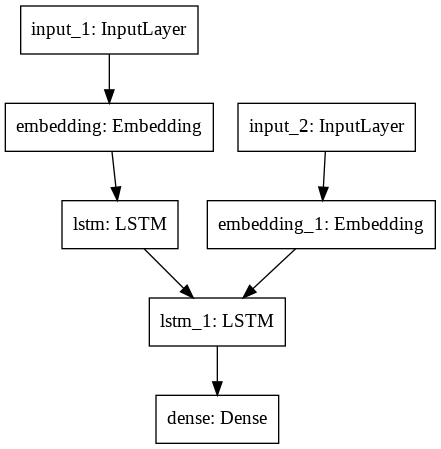

In [ ]:
#Тренировочная модель
model = Model([encoderInputs, decoderInputs],output)
model.compile(optimizer=RMSprop(),loss='categorical_crossentropy')

print(model.summary())
plot_model(model, to_file='model.png')

Epoch 1/20
186/186 [==============================] - 11s 61ms/step - loss: 1.1116
Epoch 2/20
186/186 [==============================] - 11s 61ms/step - loss: 1.1121
Epoch 3/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1120
Epoch 4/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1115
Epoch 5/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1111
Epoch 6/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1109
Epoch 7/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1114
Epoch 8/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1110
Epoch 9/20
186/186 [==============================] - 11s 59ms/step - loss: 1.1108
Epoch 10/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1108
Epoch 11/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1112
Epoch 12/20
186/186 [==============================] - 11s 60ms/step - loss: 1.1109
E

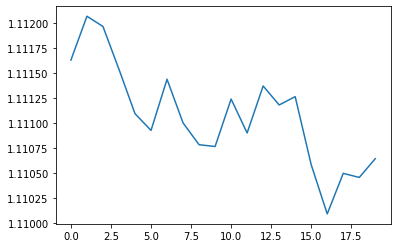

In [ ]:
#обучение и сохраним модель
history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=35, epochs=20) 
#model.save( '/content/drive/My Drive/база диалоги/model_30epochs(rms).h5' )
plt.plot(history.history['loss'], label = 'Ошибка')
plt.show()

In [ ]:
model.save( '/content/drive/My Drive/база диалоги/model_230epochs(rms).h5' )

In [ ]:
# Создаем рабочую модель для вывода ответов на запросы пользователя
def makeInferenceModels():
  #Определим модель кодера, на входе далее будут закодированные вопросы(encoderforInput), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates)
  decoderStateInput_h = Input(shape=(100 ,)) #  размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(100 ,)) #  размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе 

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём в LSTM 
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
#Функция которая преобразует текст вопроса в последовательность индексов для понимания сети
def strToTokens(sentence: str):#предложение вопроса
  words = sentence.lower().split()
  tokenlist = list()
  try:  
    for word in words:
      tokenlist.append(tokenizer.word_index[word])#определяем токенайзером индекс слова
  except:
    print('Я незнаю такого слова, спросите что-нибудь другое!')
    
    
  return pad_sequences([tokenlist], maxlen=maxLenQuestions, padding='post')

In [ ]:
#Устанавливаем окончательные настройки и запускаем модель

encModel, decModel = makeInferenceModels()

for _ in range(6):#задаеь количество вопросов
  stateValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  #Создаем пустой массив размером (1,1)
  emptyTargetSeq = np.zeros((1,1))
  emptyTargetSeq[0,0] = tokenizer.word_index['start']# положим в пустую последовательность начальное слово 'start' в виде индекса
  stopCondition = False#условие при котором прекратится генерайция слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition :
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + stateValues)
    #argmax пробежит по вектору decOutputs'а[0,0], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      

        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Как дела?
 за мной. 
Задайте вопрос : Сколько времени сейчас?
 а да! 
Задайте вопрос : Когда будешь в кино?
 так не так не так не так не так не так не так
Задайте вопрос : Ты откуда
 из с нибудь не из с нибудь не из с нибудь не и
Задайте вопрос : Сколько тебе лет
 а ты а ты а ты а ты а ты а ты а
Задайте вопрос : Какая сейчас, у тебя погода?
Я незнаю такого слова, спросите что-нибудь другое!
 ты сам ты сам ты сам ты сам ты сам ты сам ты 
